In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.constants import convert_temperature as conv_temp

In [33]:
# Load the data
data = pd.read_excel('temperature25.xlsx')

# read coefficients from csv
coeffs = pd.read_csv('HP_fitted_coefficients.csv')
S_M = coeffs['S_M'][0]
R_M = coeffs['R_M'][0]
K_M = coeffs['K_M'][0]

In [3]:
# Sort the data based on the 'Current_A' column
sorted_data = data.sort_values(by='Current_A')
sorted_data10 = sorted_data[sorted_data['DeltaT_C'] == 10]

x_filtered = sorted_data10['Current_A']
y_filtered = sorted_data10['COP']

In [4]:
# Define a rational function
def rational_func_more_terms(x, a3, a2, a1, a0, b3, b2, b1, b0):
    return (a3*x**3 + a2*x**2 + a1*x + a0) / (b3*x**3 + b2*x**2 + b1*x + b0)

# Fit the data
params_rational_more_terms, _ = curve_fit(rational_func_more_terms, x_filtered, y_filtered, maxfev=5000)
print(params_rational_more_terms)

# Calculate fitted values and R^2
y_fit_rational_more_terms = rational_func_more_terms(x_filtered, *params_rational_more_terms)
r2_rational_more_terms = r2_score(y_filtered, y_fit_rational_more_terms)
print(r2_rational_more_terms)

[-7.25721220e+01  8.69257296e+02  1.49791947e+03 -4.87481507e+02
  1.45144249e+02  2.92159993e+02  6.11185820e+01  1.39050643e-07]
1.0


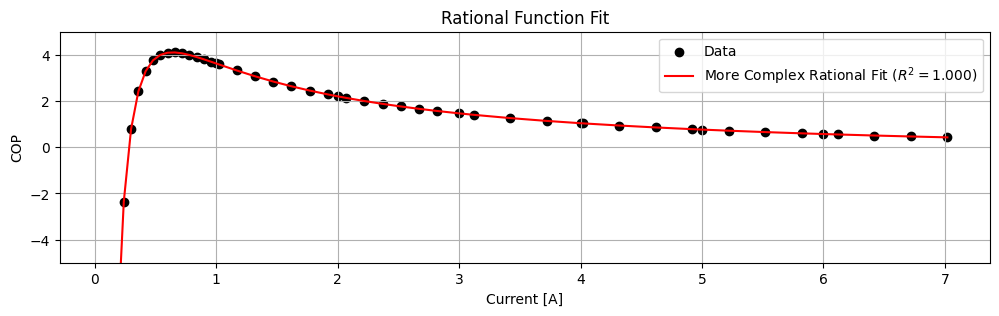

In [5]:
plt.figure(figsize=(12, 3))
plt.scatter(x_filtered, y_filtered, label='Data', color='black')
plt.plot(x_filtered, y_fit_rational_more_terms, label=f'More Complex Rational Fit ($R^2 = {r2_rational_more_terms:.3f}$)', color='red')

plt.xlabel('Current [A]')
plt.ylabel('COP')
plt.title('Rational Function Fit')
plt.ylim(-5, 5)
plt.legend()
plt.grid(True)
plt.show()

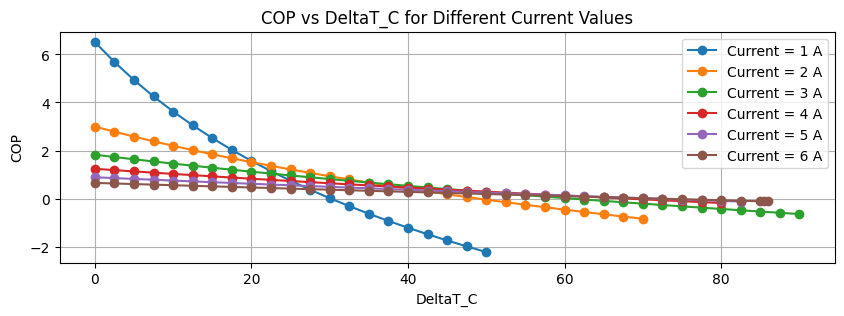

In [6]:
plt.figure(figsize=(10, 3))
for i in range(1, 7):
    current_data = data[data['Current_A'] == i]
    plt.plot(current_data['DeltaT_C'], current_data['COP'], label=f'Current = {i} A', marker='o')

plt.xlabel('DeltaT_C')
plt.ylabel('COP')
plt.title('COP vs DeltaT_C for Different Current Values')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
def voltage_fun(delta_T, I):
    return S_M * delta_T + R_M * I

def power_fun(delta_T, I):
    return I * voltage_fun(delta_T, I)

def Q_c_fun(delta_T, I, T_c_K):
    return S_M * T_c_K * I - 0.5 * R_M * I**2 - K_M * delta_T

def Q_h_fun(delta_T, I, T_h_K):
    return S_M * T_h_K * I + 0.5 * R_M * I**2 - K_M * delta_T

def COP_fun(delta_T, I, T_c_K):
    return Q_c_fun(delta_T, I, T_c_K) / power_fun(delta_T, I)


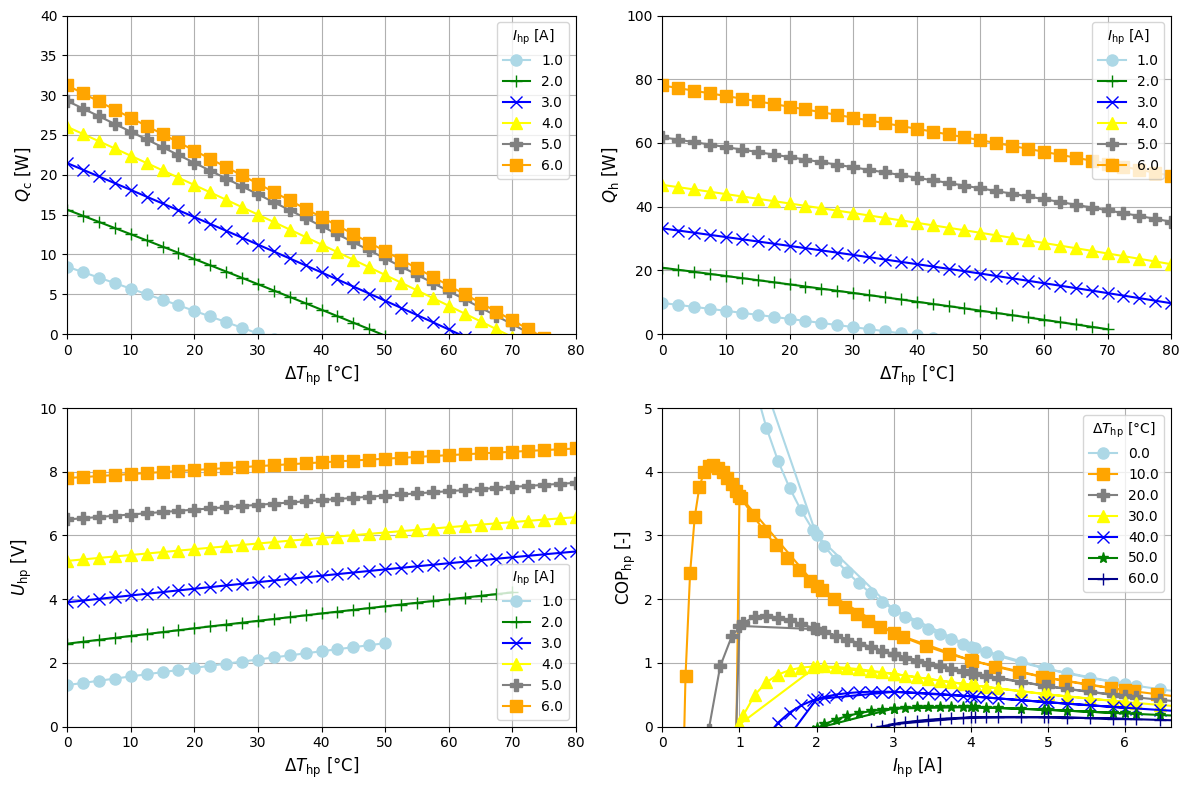

In [38]:
# Define plot limits and labels
DeltaT_x_lim = [0, 80]
current_x_lim = [0, 6.6]
voltage_y_lim = [0, 10]
heat_removed_y_lim = [0, 40]
heat_waste_y_lim = [0, 100]
cop_y_lim = [0, 5]

DeltaT_label = r'$\Delta T_\mathrm{hp}$ [°C]'
current_label = r'$I_\mathrm{hp}$ [A]'

currents_to_plot = [1, 2, 3, 4, 5, 6]
current_colors = ['lightblue', 'green', 'blue', 'yellow', 'gray', 'orange']
current_markers = ['o', '+', 'x', '^', 'P', 's']

deltaTs_to_plot = [0, 10, 20, 30, 40, 50, 60]
deltaT_colors = ['lightblue', 'orange', 'gray', 'yellow', 'blue', 'green', 'darkblue']
deltaT_markers = ['o', 's', 'P', '^', 'x', '*', '+']

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Row 1, Col 1: Heat removed plot (Qremoved_W)
for current, color, marker in zip(currents_to_plot, current_colors, current_markers):
    subset = data[data['Current_A'] == current]
    axs[0, 0].plot(
        subset['DeltaT_C'],
        subset['Qremoved_W'],
        label=f'{current:.1f}',
        color=color,
        marker=marker,
        markersize=8,
        linewidth=1.5
    )
axs[0, 0].set_xlabel(DeltaT_label, fontsize=12)
axs[0, 0].set_ylabel(r'$Q_\mathrm{c}$ [W]', fontsize=12)
axs[0, 0].set_xlim(DeltaT_x_lim)
axs[0, 0].set_ylim(heat_removed_y_lim)
axs[0, 0].legend(title=current_label, fontsize=10)
axs[0, 0].grid(True)

# Row 1, Col 2: Heat waste plot (Qwaste_W)
for current, color, marker in zip(currents_to_plot, current_colors, current_markers):
    subset = data[data['Current_A'] == current]
    axs[0, 1].plot(
        subset['DeltaT_C'],
        subset['Qwaste_W'],
        label=f'{current:.1f}',
        color=color,
        marker=marker,
        markersize=8,
        linewidth=1.5
    )
axs[0, 1].set_xlabel(DeltaT_label, fontsize=12)
axs[0, 1].set_ylabel(r'$Q_\mathrm{h}$ [W]', fontsize=12)
axs[0, 1].set_xlim(DeltaT_x_lim)
axs[0, 1].set_ylim(heat_waste_y_lim)
axs[0, 1].legend(title=current_label, fontsize=10)
axs[0, 1].grid(True)

# Row 2, Col 1: Voltage plot (Voltage_V)
for current, color, marker in zip(currents_to_plot, current_colors, current_markers):
    subset = data[data['Current_A'] == current]
    axs[1, 0].plot(
        subset['DeltaT_C'],
        subset['Voltage_V'],
        label=f'{current:.1f}',
        color=color,
        marker=marker,
        markersize=8,
        linewidth=1.5
    )
axs[1, 0].set_xlabel(DeltaT_label, fontsize=12)
axs[1, 0].set_ylabel(r'$U_\mathrm{hp}$ [V]', fontsize=12)
axs[1, 0].set_xlim(DeltaT_x_lim)
axs[1, 0].set_ylim(voltage_y_lim)
axs[1, 0].legend(title=current_label, fontsize=10)
axs[1, 0].grid(True)

# Row 2, Col 2: COP plot (COP)
for deltaT, color, marker in zip(deltaTs_to_plot, deltaT_colors, deltaT_markers):
    subset = data[data['DeltaT_C'] == deltaT]
    axs[1, 1].plot(
        subset['Current_A'],
        subset['COP'],
        label=f'{deltaT:.1f}',
        color=color,
        marker=marker,
        markersize=8,
        linewidth=1.5
    )
axs[1, 1].set_xlabel(current_label, fontsize=12)
axs[1, 1].set_ylabel(r'COP$_\mathrm{hp}$ [-]', fontsize=12)
axs[1, 1].set_xlim(current_x_lim)
axs[1, 1].set_ylim(cop_y_lim)
axs[1, 1].legend(title=DeltaT_label, fontsize=10)
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [22]:
display(data)

,Th_C,Voltage_V,DeltaT_C,Current_A,Qremoved_W,Qwaste_W,COP
0,25,7.800001,0.0,6.00,31.236227,78.036234,0.667441
1,25,7.832013,2.5,6.00,30.220875,77.212951,0.643106
2,25,7.863891,5.0,6.00,29.203086,76.386432,0.618928
3,25,7.895630,7.5,6.00,28.182809,75.556592,0.594903
4,25,7.927225,10.0,6.00,27.159997,74.723347,0.571028
...,...,...,...,...,...,...,...
573,25,8.668341,90.0,5.85,-7.148435,43.561361,-0.140968
574,25,8.983811,90.0,6.15,-7.279575,47.970862,-0.131756
575,25,9.299281,90.0,6.45,-7.505357,52.475004,-0.125130
576,25,9.614750,90.0,6.75,-7.825779,57.073786,-0.120583
